In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
import warnings
warnings.filterwarnings("ignore")

In [66]:
colspecs = [(2, 10), (10, 22), (56, 69), (82, 95)]
names = ['Data', 'Codigo', 'Preco_Abertura', 'Preco_Fechamento']

df_2022 = pd.read_fwf('COTAHIST_A2022.TXT', colspecs=colspecs, names=names, header=None)
df_2023 = pd.read_fwf('COTAHIST_A2023.TXT', colspecs=colspecs, names=names, header=None)
df_2024 = pd.read_fwf('COTAHIST_A2024.TXT', colspecs=colspecs, names=names, header=None)

frames = [df_2022, df_2023,df_2024]
df_2022a2024 = pd.concat(frames)


In [67]:
# Filtragem para conter somente o ano de 2024
AMAZON_df = df_2022a2024[df_2022a2024['Codigo'].str.endswith('AMZO34')].copy()
AMAZON_df['Data'] = pd.to_datetime(AMAZON_df['Data'], format='%Y%m%d')
AMAZON_df['Ano'] = AMAZON_df['Data'].dt.year
AMAZON_df['Mes'] = AMAZON_df['Data'].dt.month
AMAZON_df['Dia'] = AMAZON_df['Data'].dt.day
AMAZON_df.set_index('Data', inplace=True)
AMAZON_df.sort_index(inplace=True)

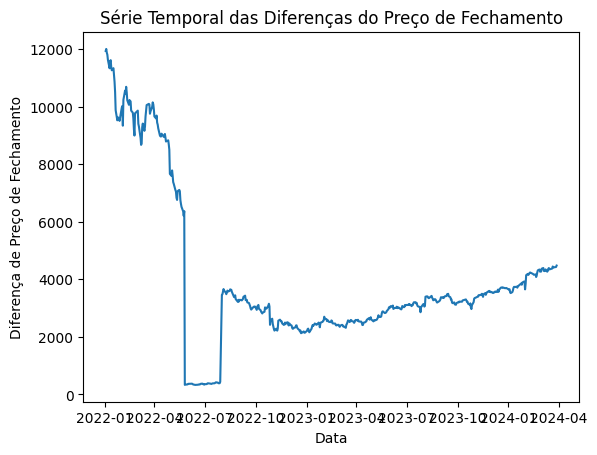

In [68]:
result = seasonal_decompose(AMAZON_df['Preco_Fechamento'], model='additive', period=30)

# Visualização da série temporal das diferenças do preço de fechamento
AMAZON_df['Diferenca'] = AMAZON_df['Preco_Fechamento']
plt.plot(AMAZON_df['Diferenca'])
plt.title('Série Temporal das Diferenças do Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Diferença de Preço de Fechamento')
plt.show()

In [69]:
# Suavização exponencial
alpha = 0.1  # Fator de suavização
model_exp = SimpleExpSmoothing(AMAZON_df['Preco_Fechamento']).fit(smoothing_level=alpha)
AMAZON_df['Suavizacao_EXP'] = model_exp.fittedvalues

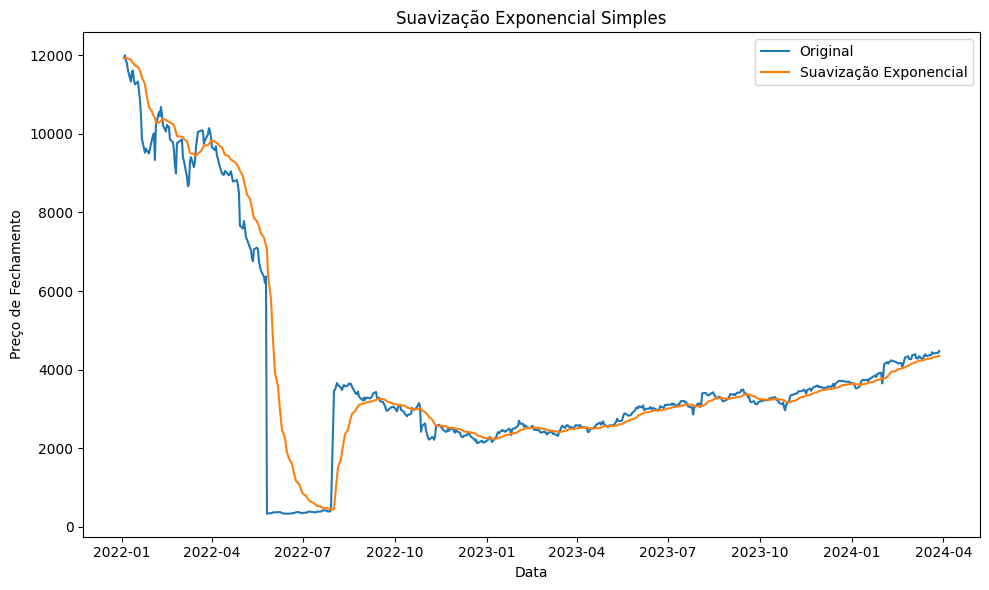

In [70]:
# Plotando a suavização exponencial
plt.figure(figsize=(10, 6))
plt.plot(AMAZON_df.index, AMAZON_df['Preco_Fechamento'], label='Original')
plt.plot(AMAZON_df.index, AMAZON_df['Suavizacao_EXP'], label='Suavização Exponencial')
plt.title('Suavização Exponencial Simples')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.tight_layout()
plt.show()

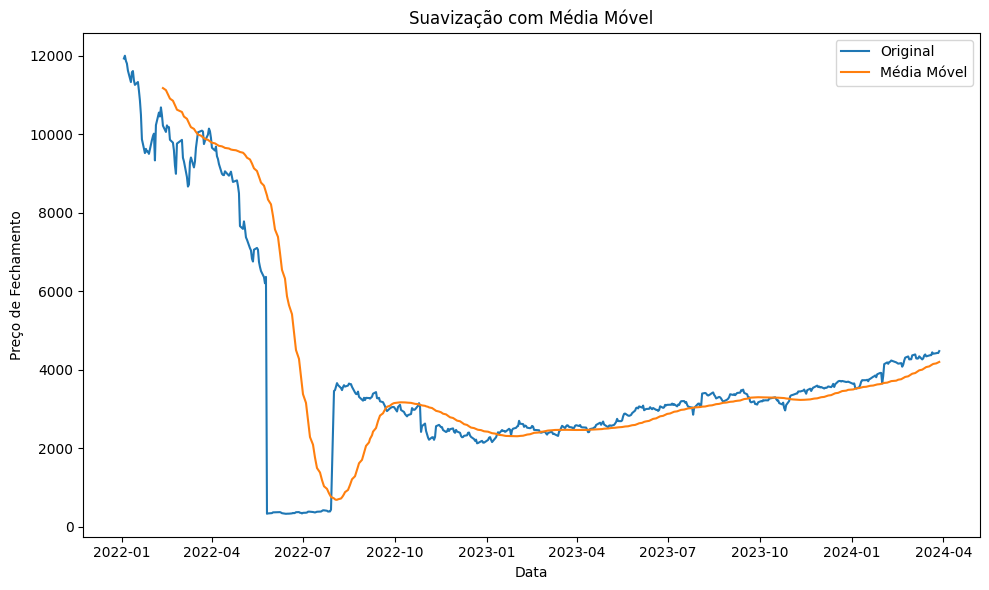

In [71]:
# Aplicando a média móvel para reduzir a sazonalidade e o ruído
window_size = 30  # Escolha o tamanho da janela de média móvel
AMAZON_df['Media_Movel'] = AMAZON_df['Suavizacao_EXP'].rolling(window=window_size).mean()

# Plotando a série original e a série suavizada pela média móvel
plt.figure(figsize=(10, 6))
plt.plot(AMAZON_df.index, AMAZON_df['Preco_Fechamento'], label='Original')
plt.plot(AMAZON_df.index, AMAZON_df['Media_Movel'], label='Média Móvel')
plt.title('Suavização com Média Móvel')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.tight_layout()
plt.show()


In [72]:

# Ajuste do modelo ARIMA nos dados suavizados
resultado_teste = adfuller(AMAZON_df['Media_Movel'].dropna())
print('Estatística do teste:', resultado_teste[0])
print('Valor-p:', resultado_teste[1])

Estatística do teste: -2.913839506646201
Valor-p: 0.043762158277344615


In [73]:
nan_indices = AMAZON_df['Media_Movel'].index[AMAZON_df['Media_Movel'].apply(np.isnan)]

# Removendo linhas com valores NaN na coluna 'Media_Movel'
AMAZON_df.drop(index=nan_indices, inplace=True)

In [74]:


 modelo_arima = auto_arima(AMAZON_df['Media_Movel'], seasonal=False, suppress_warnings=True)

 # Previsões
 horizonte = 10
 previsoes_finais = modelo_arima.predict(n_periods=horizonte)



In [75]:
previsoes_df = pd.DataFrame(previsoes_finais, columns=['Previsao'])

# Convertendo o índice para o formato de data
previsoes_df.index = pd.date_range(start=AMAZON_df.index[-1] + pd.Timedelta(days=1), periods=len(previsoes_df), freq='D')

# Convertendo para uma representação em string
texto_previsoes = previsoes_df.to_string()

print(texto_previsoes)


               Previsao
2024-03-29  4211.929070
2024-03-30  4223.151404
2024-03-31  4234.037242
2024-04-01  4244.618164
2024-04-02  4254.922783
2024-04-03  4264.977027
2024-04-04  4274.804393
2024-04-05  4284.426171
2024-04-06  4293.861655
2024-04-07  4303.128326


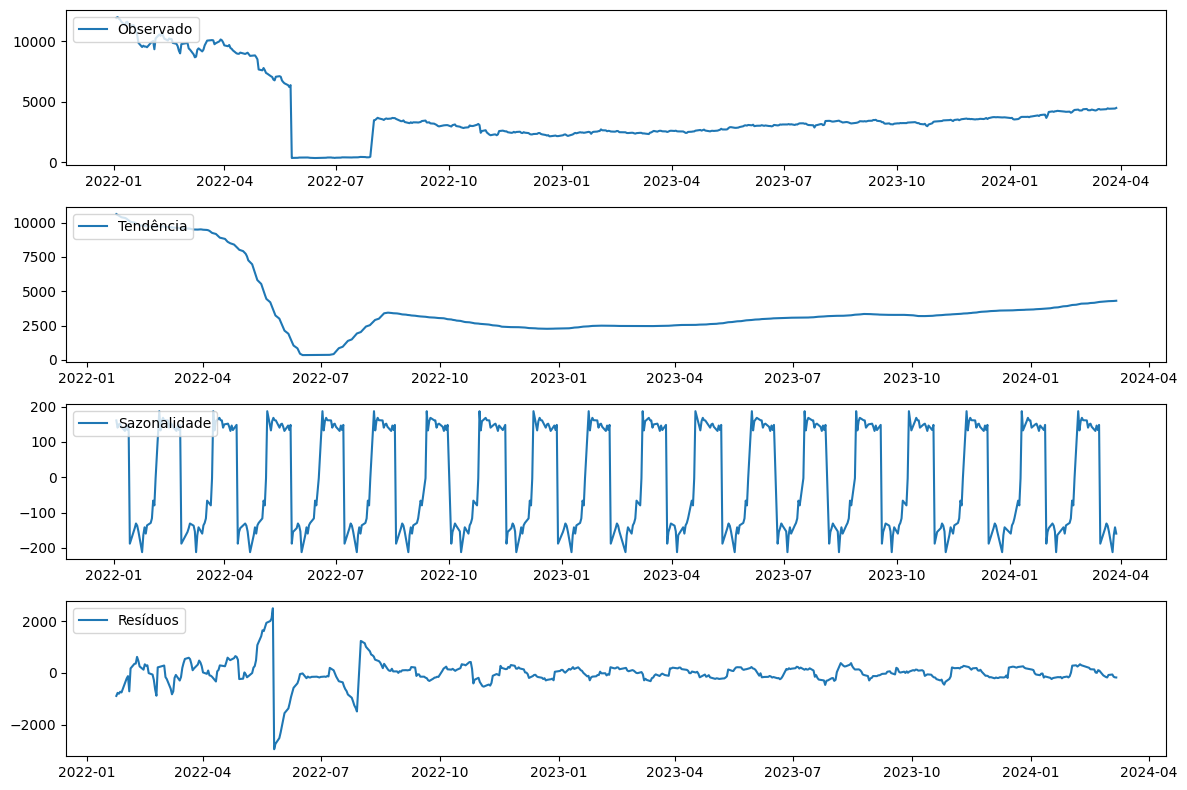

In [76]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Observado')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Tendência')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Sazonalidade')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Resíduos')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

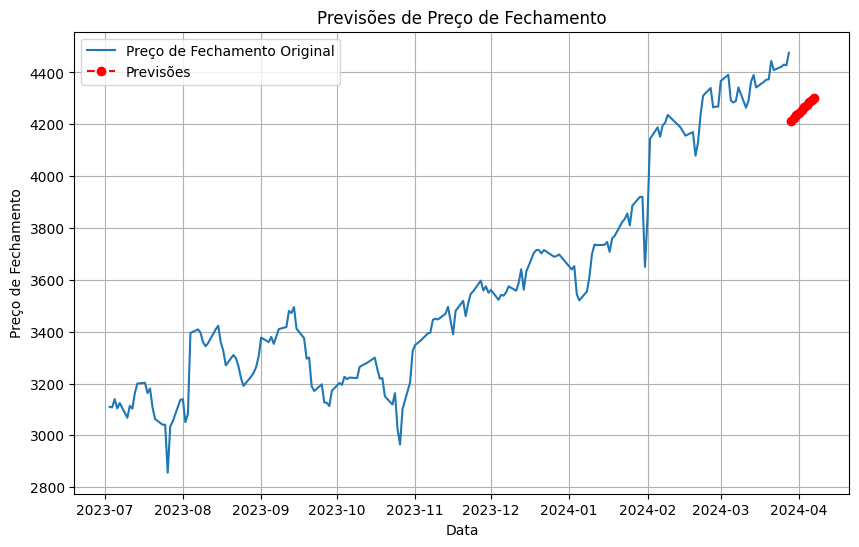

In [80]:
data_inicio = '2023-07-01'

# Selecionando os dados a partir da data de início
AMAZON_df_plot = AMAZON_df[data_inicio:]
previsoes_df_plot = previsoes_df[data_inicio:]

# Plot das previsões
plt.figure(figsize=(10, 6))
plt.plot(AMAZON_df_plot.index, AMAZON_df_plot['Preco_Fechamento'], label='Preço de Fechamento Original')
plt.plot(previsoes_df_plot.index, previsoes_df_plot['Previsao'], marker='o', linestyle='--', color='red', label='Previsões')
plt.title('Previsões de Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

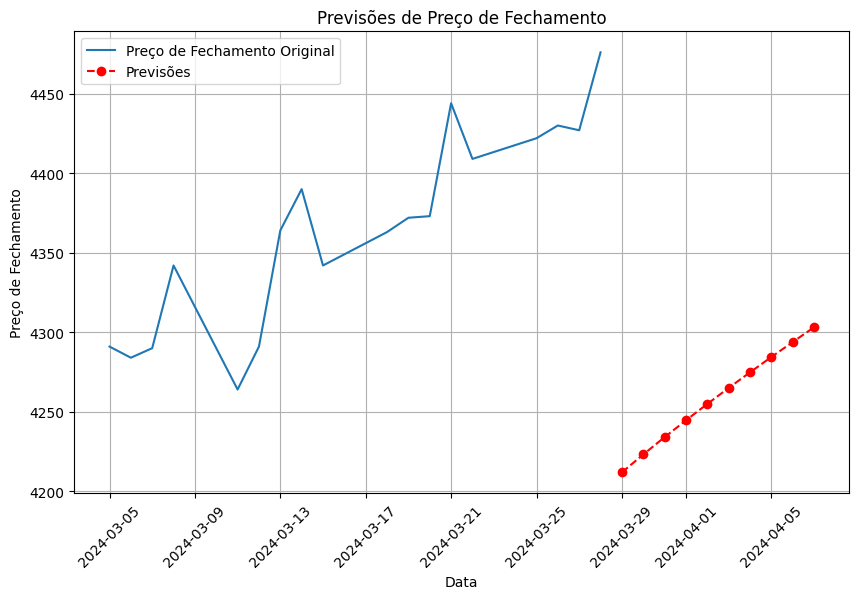

In [78]:
# Definindo a data de início
data_inicio = '2024-03-05'

# Selecionando os dados a partir da data de início
AMAZON_df_plot = AMAZON_df[data_inicio:]
previsoes_df_plot = previsoes_df[data_inicio:]

# Plot das previsões
plt.figure(figsize=(10, 6))
plt.plot(AMAZON_df_plot.index, AMAZON_df_plot['Preco_Fechamento'], label='Preço de Fechamento Original')
plt.plot(previsoes_df_plot.index, previsoes_df_plot['Previsao'], marker='o', linestyle='--', color='red', label='Previsões')
plt.title('Previsões de Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)  # Rotação de 45 graus no eixo x
plt.legend()
plt.grid(True)

plt.show()

resultado sem suavização 

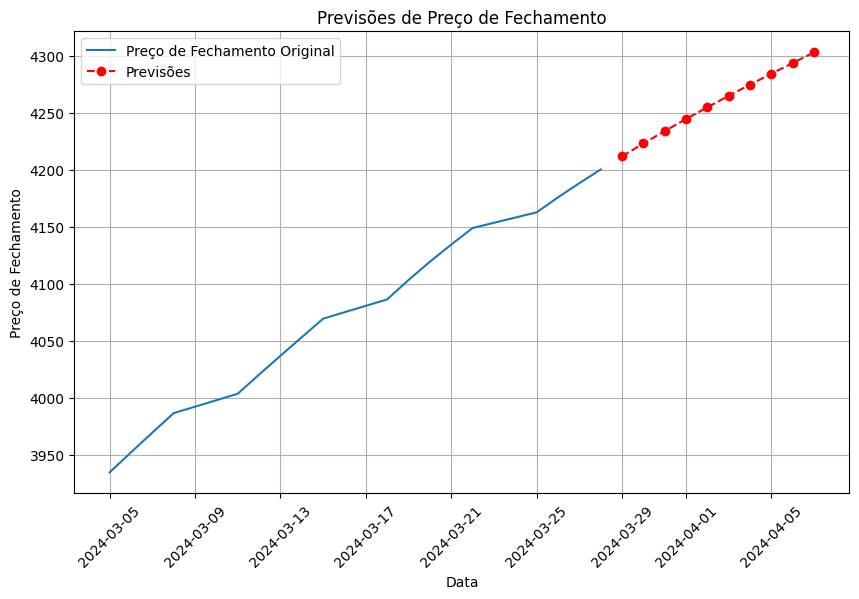

In [79]:
# Definindo a data de início
data_inicio = '2024-03-05'

# Selecionando os dados a partir da data de início
AMAZON_df_plot = AMAZON_df[data_inicio:]
previsoes_df_plot = previsoes_df[data_inicio:]

# Plot das previsões
plt.figure(figsize=(10, 6))
plt.plot(AMAZON_df_plot.index, AMAZON_df_plot['Media_Movel'], label='Preço de Fechamento Original')
plt.plot(previsoes_df_plot.index, previsoes_df_plot['Previsao'], marker='o', linestyle='--', color='red', label='Previsões')
plt.title('Previsões de Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)  # Rotação de 45 graus no eixo x
plt.legend()
plt.grid(True)

plt.show()

resultado com suavização 